#Classical neural networks.


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from torch.optim import Adam
from torchsummary import summary
from torchtext import datasets, data
from torchtext.vocab import GloVe, FastText
from tqdm import tqdm, trange

##Data preparation.

In this notebook we will load torchtext imdb dataset. According to its documentation (https://pytorch.org/text/_modules/torchtext/datasets/imdb.html) it contains the same dataset we used in previous notebook. The benefits of such usage is that torchtext provides iterators which load data by batches with padding automatically.

In [60]:
torch.cuda.set_device(0)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

train, test = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
TEXT.build_vocab(train, vectors=GloVe('6B', dim=300))
LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [06:33, 2.19MB/s]                           
100%|█████████▉| 399621/400000 [00:42<00:00, 9169.90it/s]

In [61]:
BATCH_SIZE = 64
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=BATCH_SIZE, device=DEVICE)

In [62]:
val_data = []
for i, batch in enumerate(test_iter):
    val_data.append(batch)
    if i == 30:
        break

Let's check the structure of batches in iterators:

In [7]:
for batch in train_iter:
    print('Text tensor shape: ', batch.text[0].shape)
    print('Text example: ', batch.text[0][0])
    print('Tensor of texts\' lenghts: ', batch.text[1])
    print('Labels tensor:', batch.label)
    break

Text tensor shape:  torch.Size([64, 1051])
Text example:  tensor([  9, 200,  10,  ...,   1,   1,   1], device='cuda:0')
Tensor of texts' lenghts:  tensor([ 108,  140,  382,  121,  141,  321,  331,  205,  288,  220,  129,  341,
          89,  277,  281,  126,  160,  129,   95,   80,  166,  216,  117,   78,
          63,  186,   83,  155,  138,  117,   63,  153,  830,  209,  275,   74,
          62,   97,  375,  165,  187,  476,  379,  110,  212,  231,  389,  276,
         130,  265,   37,   89,  140,  156,  275,  302,  156,  355,  147,  312,
          32,  249,  139, 1051], device='cuda:0')
Labels tensor: tensor([1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2], device='cuda:0')


We can see that classes have numbers 1 and 2, so we will remind this later to compute loss correctly. We will pass batch.text to our models in order to save all information about texts and their lengths. We can also admit that text example ends with multiple 1s, so this number corresponds to index of padding symbol.

##Helper functions for models training and quality evaluation.

First we need a loss function for classification problem. Therefore it will be crossentropy.

In [63]:
def compute_loss(batch_pred, batch_true):
    return nn.CrossEntropyLoss()(batch_pred, batch_true - 1)

As for pre-neural methods we will evaluate some quality metrics: accuracy, precision, recall and area under precision-recall curve.

In [64]:
def get_all_y(model, data, predict_proba=False):
    y_true = []
    y_pred = []
    for batch in data:
        y_true.extend(list((batch.label - 1).cpu().detach().numpy()))
        if not predict_proba:
            y_pred.extend(list(model.predict(batch.text).cpu().detach().numpy()))
        else:
            y_pred.extend(list(model(batch.text).cpu().detach().numpy()))
    return np.array(y_true), np.array(y_pred)


def get_scores(model, data, print_scores=False, from_iter=False):
    if not from_iter:
        y_true = (data.label - 1).cpu().detach().numpy()
        y_pred = model.predict(data.text).cpu().detach().numpy()
    else:
        y_true, y_pred = get_all_y(model, data)

    scores = [accuracy_score(y_true, y_pred), 
              precision_score(y_true, y_pred), 
              recall_score(y_true, y_pred)]

    if print_scores:
        print('Scores for {}:'.format(model.name))
        print('Accuracy: {}'.format(scores[0]))
        print('Precision: {}'.format(scores[1]))
        print('Recall: {}'.format(scores[2]))
    
    return np.array(scores)


def plot_roc_curve(model, data):
    y_true, y_pred = get_all_y(model, data, predict_proba=True)

    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1], pos_label=1)
    plt.figure(figsize=(15, 8))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid(c='g')
    plt.title('ROC-curve for {}'.format(model.name))
    auc_score = auc(fpr, tpr)
    print('Area under ROC-curve: {:1.4f}'.format(auc_score))
    plt.plot(fpr, tpr)
    plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r')
    plt.show()

Finally we need a train function that takes a model, its optimizer and iterators for data loading and iterates for chosen amount of epochs.

In [121]:
def train_model(model, opt, train_iter, val_iter, n_epochs=1):
    metrics = {'train_loss': [], 'val_loss': [], 'val_accuracy': [] }

    step = 0
    for i in tqdm(range(n_epochs)):
        for batch in train_iter:
            step += 1
            model.train()
            
            loss_t = compute_loss(model(batch.text), batch.label)
            opt.zero_grad()
            loss_t.backward()
            opt.step()
    

            if step % 100 == 99:
                model.eval()
                metrics['train_loss'].append(loss_t.item())

                val_losses = []
                for val_batch in val_iter:
                    val_losses.append(compute_loss(model(val_batch.text), val_batch.label).item())
                metrics['val_loss'].append(np.mean(np.array(val_losses)))

                val_true, val_pred = get_all_y(model, val_iter)
                metrics['val_accuracy'].append(accuracy_score(val_true, val_pred))
    
        model.eval()
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot((np.arange(len(history)) + 1) * 100, history)
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-5:], axis=0), flush=True)

##Part 1. Fully-connected neural network.

In this part we will create a simple fully-connected neural network. It will also train word embeddings inside it and use mean text embeddings. We can illustrate layers dimentions of the network by the following scheme:

| layer      | units | dropout | activalion | 
|------------|-------|---------|------------|
| embeddings | 300   | None    | None       |
| linear1    | 1024  | 0.2     | ReLU       |
| linear2    | 512   | 0.2     | ReLU       |
| linear3    | 256   | 0.2     | ReLU       |
| linear4    | 128   | 0.2     | ReLU       |
| linear5    | 64    | 0.2     | ReLU       |
| linear6    | 32    | None    | ReLU       |
| linear7    | 2     | None    | None       |


Outputs of the last layer will be treated as logits of classes 0 (negative) and 1 (positive).

In [117]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, vocab_size=len(TEXT.vocab), emb_size=300):
        super().__init__()
        self.name = 'Fully-connected neural network'

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.model = nn.Sequential(
            nn.Linear(emb_size, 1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
        
    def forward(self, input):
        text_embeddings = self.embeddings(input[0]) # [batch_size, sentence_len, emb_size]
        text_embeddings = torch.mean(text_embeddings, dim=1).squeeze() # [batch_size, emb_size]

        return self.model(text_embeddings) # [batch_size, 2]

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

In [126]:
fully_conn = FullyConnectedNetwork().to(DEVICE)

In [127]:
optim = Adam(fully_conn.parameters(), lr=1e-3)

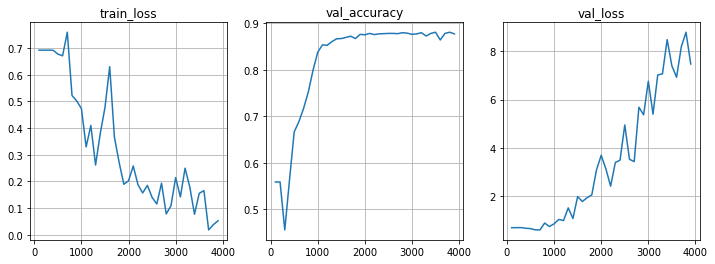

Mean loss=0.086






100%|██████████| 10/10 [02:52<00:00, 17.25s/it]


In [128]:
train_model(fully_conn, optim, train_iter, val_data, n_epochs=10)

Let's evaluate metrics on train dataset to see if we need to train longer:

Scores for Fully-connected neural network:
Accuracy: 0.96984
Precision: 0.946819841752891
Recall: 0.9956
Area under ROC-curve: 0.9984


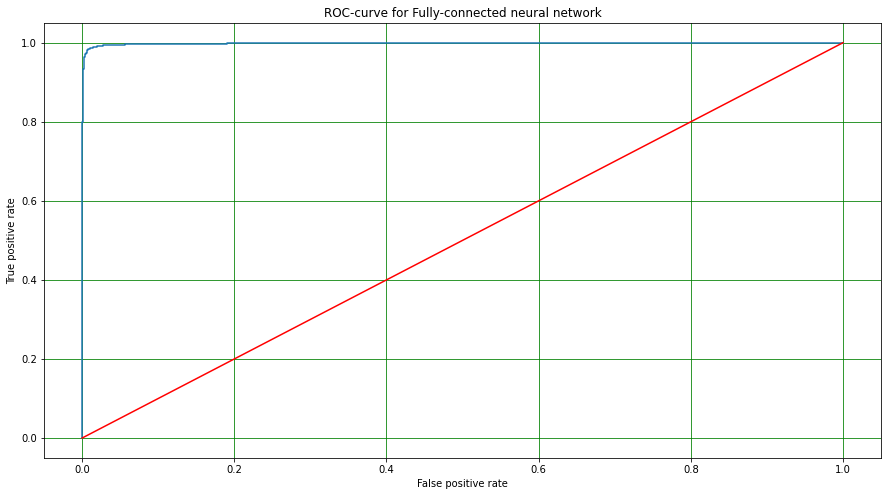

In [ ]:
get_scores(fully_conn, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(fully_conn, train_iter)

Now let's check metrics on test dataset and compare them to the best values from pre-neural notebook.

Scores for Fully-connected neural network:
Accuracy: 0.88044
Precision: 0.8648254698887611
Recall: 0.90184
Area under ROC-curve: 0.9492


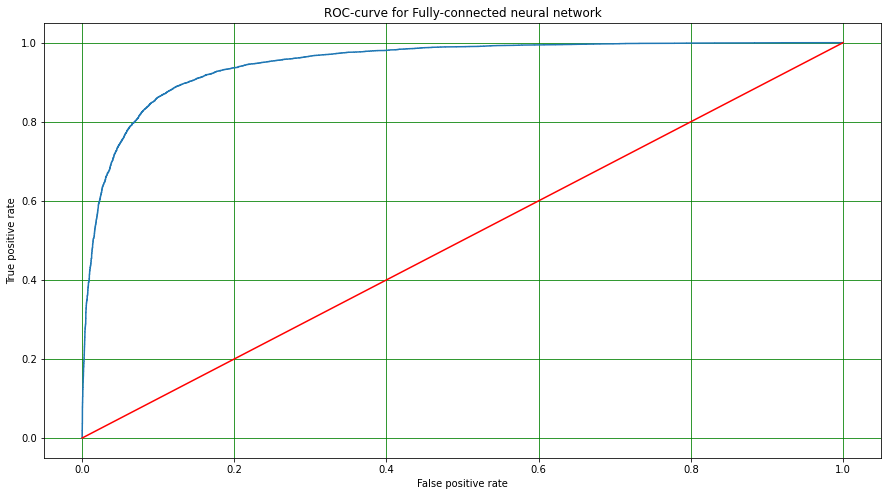

In [ ]:
get_scores(fully_conn, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(fully_conn, test_iter)

The scores are relatively good: accuracy is a bit bigger (+0.02), we have the same precision and bigger recall (+0.05), area under precision-recall curve has also increased (+0.016), so this shows that simple fully-connected network works not worse than pre-neural methods. It only took 10 epochs for it to converge to good scores.

Model               | Accuracy | Precision | Recall | Roc-auc
--------------------|----------|-----------|--------|--------
LogisticRegression  | 0.861    | 0.862     | 0.860  | 0.932
Fully-connected NN  | 0.880    | 0.865     | 0.901  | 0.949


##Part 2. Recurrent neural network.

In this part we will construct two models based on LSTM and GRU and compare their performances. Both of them will have main block (LSTM of GRU) and linear head that transforms the last output of main part to logits of classes 0 and 1. We also should remember that texts in batches are padded by PAD token (here it has id 1), so for each text we need to take output for the last non-padding token.

###LSTM-based neural network.

In [130]:
class LSTMNetwork(nn.Module):
    def __init__(self, vocab_size=len(TEXT.vocab), emb_size=300, hidden_size=256):
        super().__init__()
        self.name = 'LSTM neural network'

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.linear_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input):
        text_embeddings = self.embeddings(input[0]) # [batch_size, sentence_len, emb_size]

        lstm_output, _ = self.lstm(text_embeddings) # [batch_size, sentence_len, hid_size]
        rows = torch.arange(lstm_output.shape[0]).type(torch.LongTensor).to(DEVICE)
        lstm_last_output = lstm_output[rows, input[1] - 1, :].squeeze() # [batch_size, hid_size]

        return self.linear_head(lstm_last_output) # [batch_size, 2]

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

In [131]:
lstm_net = LSTMNetwork().to(DEVICE)
optim = Adam(lstm_net.parameters(), lr=1e-3)

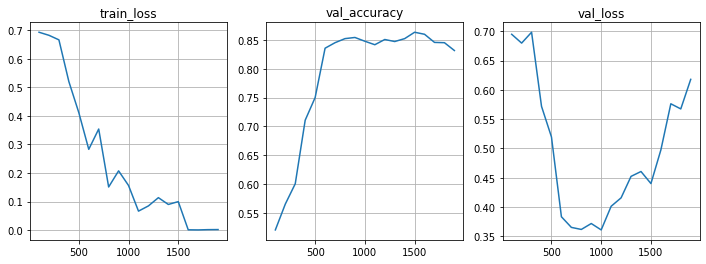

Mean loss=0.021






100%|██████████| 5/5 [04:15<00:00, 51.05s/it]


In [132]:
train_model(lstm_net, optim, train_iter, val_data, n_epochs=5)

According to train loss and dev accuracy, we don't need to train more, let's check scores on train and test data.

Scores for LSTM neural network:
Accuracy: 0.99884
Precision: 0.9987203071262897
Recall: 0.99896
Area under ROC-curve: 1.0000


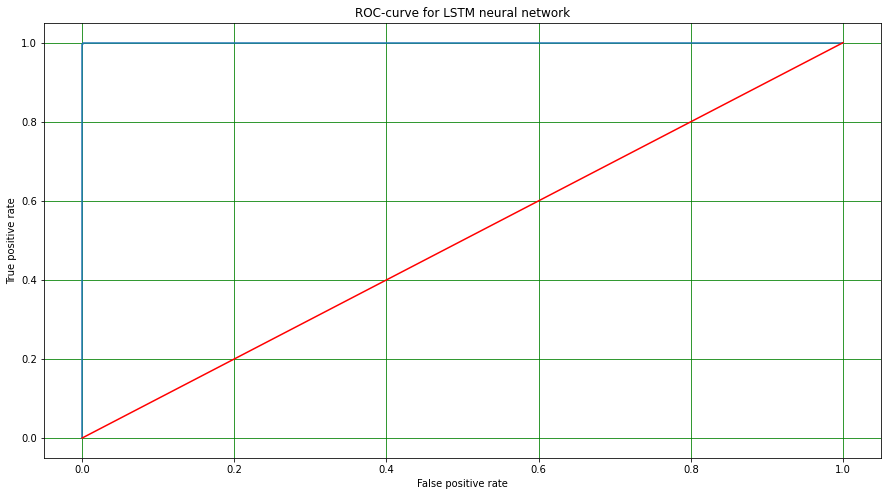

In [133]:
get_scores(lstm_net, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(lstm_net, train_iter)

Scores for LSTM neural network:
Accuracy: 0.85232
Precision: 0.879328165374677
Recall: 0.81672
Area under ROC-curve: 0.9276


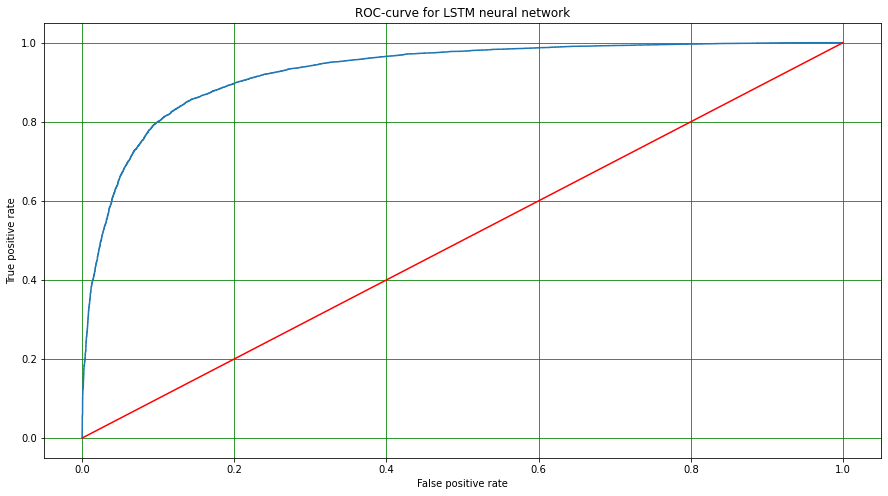

In [134]:
get_scores(lstm_net, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(lstm_net, test_iter)

We can see a perfect performance on train data and comparatively normal results on test data. Let's also try another RNN.

###GRU-based neural network.

This part is almost similar to LSTM since we just change main part to GRU and create similar network.

In [ ]:
class GRUNetwork(nn.Module):
    def __init__(self, vocab_size=len(TEXT.vocab), emb_size=300, hidden_size=256):
        super().__init__()
        self.name = 'GRU neural network'

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.gru = nn.GRU(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.linear_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input):
        text_embeddings = self.embeddings(input[0]) # [batch_size, sentence_len, emb_size]

        gru_output, _ = self.gru(text_embeddings) # [batch_size, sentence_len, hid_size]
        rows = torch.arange(gru_output.shape[0]).type(torch.LongTensor).to(DEVICE)
        gru_last_output = gru_output[rows, input[1] - 1, :].squeeze() # [batch_size, hid_size]

        return self.linear_head(gru_last_output) # [batch_size, 2]

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

In [ ]:
gru_net = GRUNetwork().to(DEVICE)
optim = Adam(gru_net.parameters(), lr=1e-3)

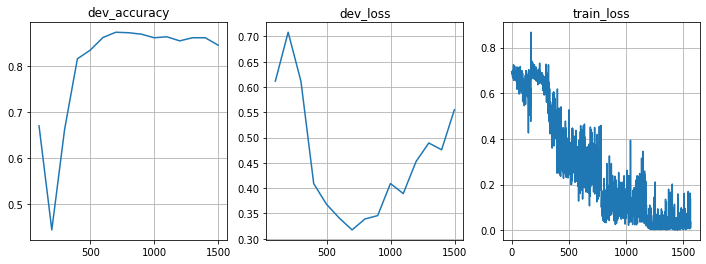

Mean loss=0.049



100%|██████████| 4/4 [03:06<00:00, 46.59s/it]


In [ ]:
train_model(gru_net, optim, train_iter, val_data, n_epochs=4)

We can see that after only 4 epochs dev accuracy has converged and our model fitted train data perfectly, so let's check the scores.

Scores for GRU neural network:
Accuracy: 0.99888
Precision: 0.9985609210105533
Recall: 0.9992
Area under ROC-curve: 0.9998


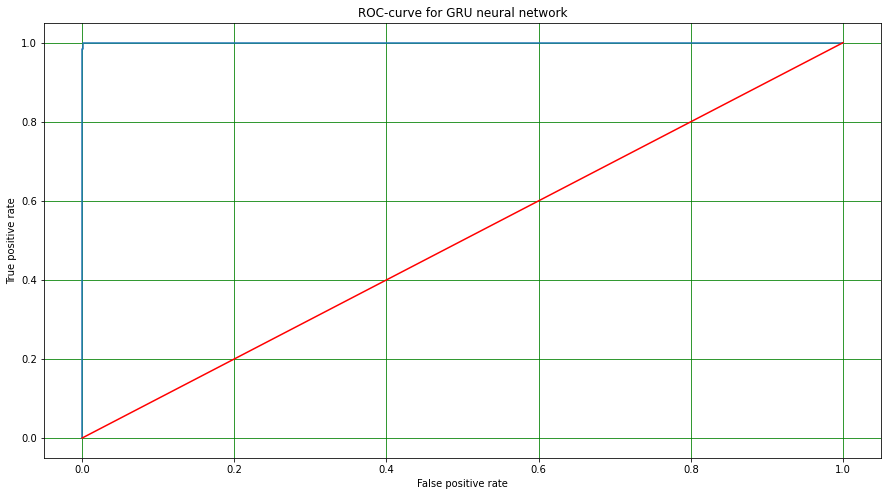

In [ ]:
get_scores(gru_net, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(gru_net, train_iter)

Scores for GRU neural network:
Accuracy: 0.8502
Precision: 0.9065663601746076
Recall: 0.78088
Area under ROC-curve: 0.9354


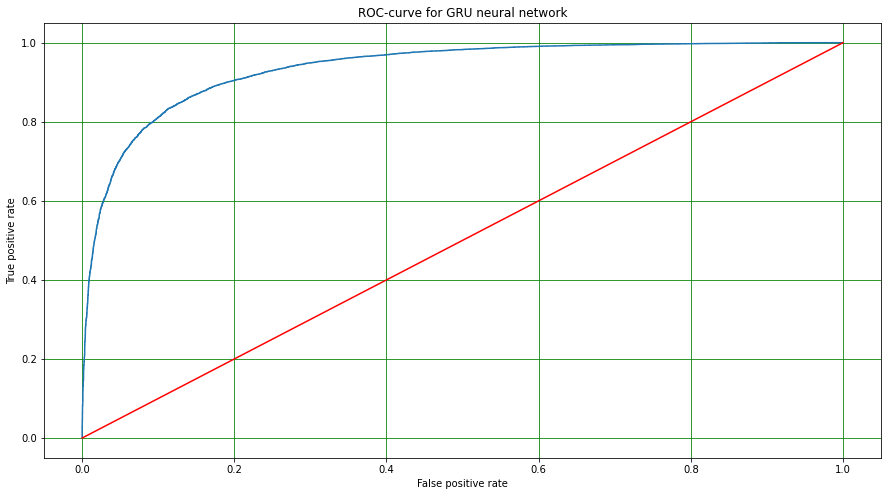

In [ ]:
get_scores(gru_net, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(gru_net, test_iter)

Total performance on test data is still worse than for fully-connected neural network, but generally it reached the level of logistic regressions's scores from the first notebook. Now we can compare all four models together:

Model               | Accuracy | Precision | Recall | Roc-auc
--------------------|----------|-----------|--------|--------
LogisticRegression  | 0.861    | 0.862     | 0.860  | 0.932
Fully-connected NN  | 0.880    | 0.865     | 0.901  | 0.949
LSTM-based NN       | 0.852    | 0.879     | 0.817  | 0.928
GRU-based NN        | 0.850    | 0.907     | 0.781  | 0.935

##Part 3. Convolutional neural network.

If we want to use convolutions in neural network we need to reshape all texts to the same lenghts. So, first we need to find the length of the longest text in train and text datasets.

In [ ]:
max_len = max(map(max, list(map(lambda x: x.text[0].shape[1], data_iter) for data_iter in [train_iter, test_iter])))
print(max_len)

2470


In this part we will create a simple convolutional neural network. It will have main part with four convolutional layers with kernel of size 3, ReLU activation and MaxPooling also with kernel of size 3 and stride equal to 3. Last MaxPooling will work as GlobalPooling, so its' kernel size and stride will be set to 77 (see numbers in comments that follow shapes of batch after each layer). 

After that layer we will get 1024 features for each text and to transform them to logits of classes 0 and 1 we will create a two-layer fully-connected neural network.

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, vocab_size=len(TEXT.vocab), emb_size=300, max_len=max_len):
        super().__init__()
        self.name = 'Convolutional neural network'
        self.max_len = max_len
        self.emb_size = emb_size

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.model = nn.Sequential(
            nn.Conv1d(emb_size, 128, kernel_size=3), # [batch_size, 128, 2468]
            nn.ReLU(),
            nn.MaxPool1d(3, 3), # [batch_size, 128, 822]
            nn.Conv1d(128, 256, kernel_size=3), # [batch_size, 256, 820]
            nn.ReLU(),
            nn.MaxPool1d(3, 3), # [batch_size, 256, 273]
            nn.Conv1d(256, 512, kernel_size=3), # [batch_size, 512, 237]
            nn.ReLU(),
            nn.MaxPool1d(3, 3), # [batch_size, 512, 79]
            nn.Conv1d(512, 1024, kernel_size=3), # [batch_size, 1024, 77]
            nn.ReLU(),
            nn.MaxPool1d(77, 77), # [batch_size, 1024, 1]
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        
        
    def forward(self, input):
        padded_input = torch.ones(input[0].shape[0], self.max_len).type(torch.LongTensor).to(DEVICE)
        padded_input[:, :input[0].shape[1]] = input[0] # [batch_size, max_len]

        text_embeddings = self.embeddings(padded_input) # [batch_size, max_len, emb_size]
        text_embeddings = text_embeddings.permute(0, 2, 1) # [batch_size, emb_size, max_len]

        return self.model(text_embeddings) # [batch_size, 2]

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

In [ ]:
cnn = ConvolutionalNeuralNetwork().to(DEVICE)
optim = Adam(cnn.parameters(), lr=1e-3)

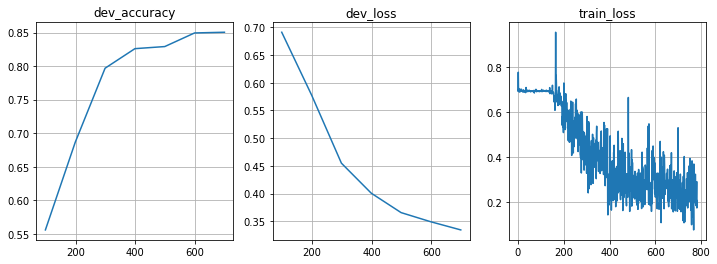

Mean loss=0.240



100%|██████████| 2/2 [01:49<00:00, 54.91s/it]


In [ ]:
train_model(cnn, optim, train_iter, val_data, n_epochs=2)

Scores for Convolutional neural network:
Accuracy: 0.96492
Precision: 0.9542008597108246
Recall: 0.97672
Area under ROC-curve: 0.9940


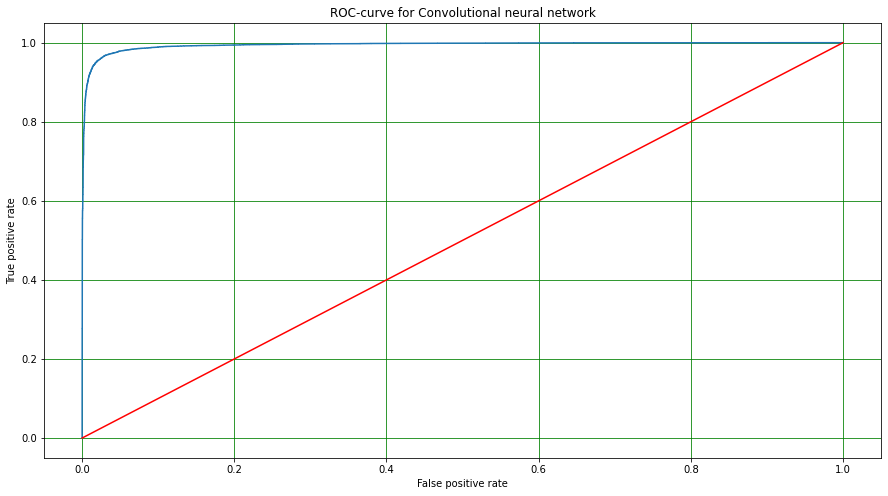

In [ ]:
get_scores(cnn, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(cnn, train_iter)

Scores for Convolutional neural network:
Accuracy: 0.86948
Precision: 0.8610741927918067
Recall: 0.88112
Area under ROC-curve: 0.9438


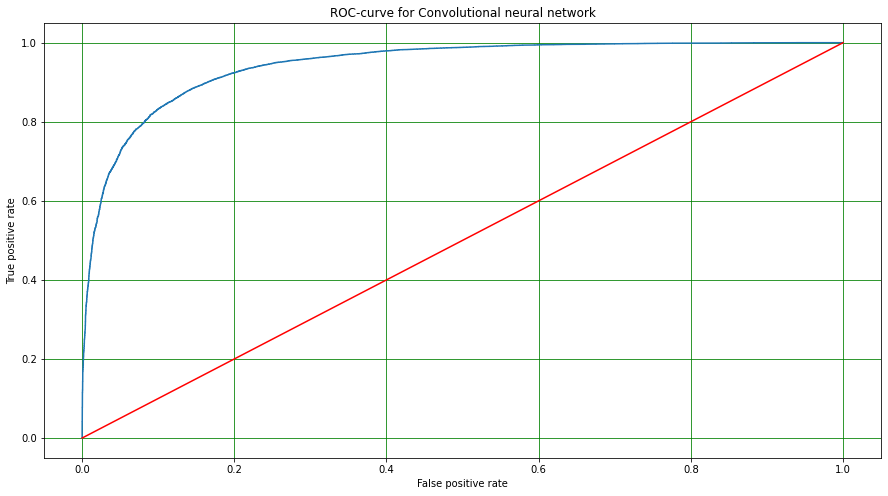

In [ ]:
get_scores(cnn, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(cnn, test_iter)

Scores of CNN on test dataset are pretty good: bigger accuracy (**+0.01**) and recall (**+0.02**) compared to logistic regression, area under precision-recall curve has also increased (**+0.01**). But if we compare these results to the ones of fully-connected network, cnn is a bit worse.

Now we can build total scoreboard for research of this notebook!

Model               | Accuracy | Precision | Recall | Roc-auc
--------------------|----------|-----------|--------|--------
LogisticRegression  | 0.861    | 0.862     | 0.860  | 0.932
Fully-connected NN  | 0.880    | 0.865     | 0.901  | 0.949
LSTM-based NN       | 0.852    | 0.879     | 0.817  | 0.928
GRU-based NN        | 0.850    | 0.907     | 0.781  | 0.935
CNN                 | 0.869    | 0.861     | 0.881  | 0.944

As we can see fully-connected NN has the best roc-auc, recall and accuracy. GRU has the best precision. All models are comparatively good and have not bad scores, but we can mention fully-connected NN as the best one in this part. Final scores are pretty good!